# Quantization: Bitsandbytes 4-bit

**Objective:** Compare FP16 vs NF4 vs FP4, quantify functional distortion amplification, and relate practical error to Gaussian / GGD bounds.

In [ ]:
# === AUTHENTICATION (required) ===
from huggingface_hub import login
# Paste your token directly as a string argument
login(token="...")
# After running successfully, DELETE this cell or clear the token string

In [2]:
# dependency install
%pip -q install -U transformers accelerate bitsandbytes scipy
# restart after installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 128.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 19.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 19.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 47.8 MB/s eta 0:00:00


In [1]:
# Core imports
import math
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from scipy import stats
from scipy.stats import gennorm, entropy
from scipy.special import gamma

In [2]:
# Load model + tokenizer (Llama 3.2 1B by default)
model_id = "meta-llama/Llama-3.2-1B"

tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)

# FP16 baseline
m_fp16 = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
).eval()

# Keep the original variable name for downstream cells
model = m_fp16
print(f"Loaded: {model_id}")
print(f"Parameters: {model.num_parameters()/1e9:.2f}B")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Loaded: meta-llama/Llama-3.2-1B
Parameters: 1.24B


In [3]:
# ============================================
# Load bitsandbytes 4-bit Quantized Models
# ============================================

# FP16 baseline already loaded as `model` (m_fp16)

print("Loading bnb 4-bit NF4 model...")
try:
    q_nf4 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4")
    m_nf4 = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        quantization_config=q_nf4,
    ).eval()

    model_nf4 = m_nf4
    NF4_AVAILABLE = True
    print("✓ NF4 model loaded successfully")

except Exception as e:
    print(f"✗ NF4 model loading failed: {e}")
    print("  Install with: pip install bitsandbytes")
    model_nf4 = None
    NF4_AVAILABLE = False

print("Loading bnb 4-bit FP4 model...")
try:
    q_fp4 = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="fp4")
    m_fp4 = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        quantization_config=q_fp4,
    ).eval()

    model_fp4 = m_fp4
    FP4_AVAILABLE = True
    print("✓ FP4 model loaded successfully")

except Exception as e:
    print(f"✗ FP4 model loading failed: {e}")
    model_fp4 = None
    FP4_AVAILABLE = False

print(f"Model availability summary:")
print(f"  FP16 baseline: ✓ (already loaded)")
print(f"  bnb 4-bit NF4: {'✓' if NF4_AVAILABLE else '✗'}")
print(f"  bnb 4-bit FP4: {'✓' if FP4_AVAILABLE else '✗'}")

Loading bnb 4-bit NF4 model...


Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]

✓ NF4 model loaded successfully
Loading bnb 4-bit FP4 model...


Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]

✓ FP4 model loaded successfully
Model availability summary:
  FP16 baseline: ✓ (already loaded)
  bnb 4-bit NF4: ✓
  bnb 4-bit FP4: ✓


## 2. Weight MSE Comparison

In [4]:
# Target layer for comparison
target_layer = 8

# Extract FP16 baseline weights
w_fp16 = model.model.layers[target_layer].mlp.down_proj.weight.detach().cpu().float().numpy()


def extract_module_weight(module):
    """Return dequantized weights for bnb 4-bit modules, or raw weights otherwise."""
    w = module.weight
    if hasattr(w, "quant_state"):
        try:
            import bitsandbytes as bnb
            w_deq = bnb.functional.dequantize_4bit(w.data, w.quant_state)
            return w_deq.detach().cpu().float().numpy()
        except Exception:
            pass
        if hasattr(w, "dequantize"):
            return w.dequantize().detach().cpu().float().numpy()
    return w.detach().cpu().float().numpy()


sigma = float(np.std(w_fp16))
d_shannon_gauss = sigma ** 2 / (4 ** 4)  # 4-bit Gaussian bound

mse_nf4 = None
mse_fp4 = None

if NF4_AVAILABLE and model_nf4 is not None:
    w_nf4 = extract_module_weight(model_nf4.model.layers[target_layer].mlp.down_proj)
    mse_nf4 = float(np.mean((w_fp16 - w_nf4) ** 2))

if FP4_AVAILABLE and model_fp4 is not None:
    w_fp4 = extract_module_weight(model_fp4.model.layers[target_layer].mlp.down_proj)
    mse_fp4 = float(np.mean((w_fp16 - w_fp4) ** 2))

rows = []
if mse_nf4 is not None:
    rows.append({
        "method": "bnb 4-bit NF4",
        "weight_mse": mse_nf4,
        "gap_bits_vs_gauss": 0.5 * np.log2(mse_nf4 / d_shannon_gauss),
    })
if mse_fp4 is not None:
    rows.append({
        "method": "bnb 4-bit FP4",
        "weight_mse": mse_fp4,
        "gap_bits_vs_gauss": 0.5 * np.log2(mse_fp4 / d_shannon_gauss),
    })

rows.append({
    "method": "Shannon bound (Gaussian)",
    "weight_mse": d_shannon_gauss,
    "gap_bits_vs_gauss": 0.0,
})

summary_weights = pd.DataFrame(rows)
print(summary_weights.to_string(index=False))

                  method  weight_mse  gap_bits_vs_gauss
           bnb 4-bit NF4    0.000002           0.589341
           bnb 4-bit FP4    0.000004           1.027617
Shannon bound (Gaussian)    0.000001           0.000000


## 3. Functional Distortion

In [5]:
# Simplified calibration data
calibration_texts = ["The quick brown fox jumps over the lazy dog."] * 100

if tok.pad_token is None:
    tok.pad_token = tok.eos_token

calibration_inputs = tok(
    calibration_texts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128,
)


def iter_batches(inputs, batch_size):
    n = inputs["input_ids"].size(0)
    for i in range(0, n, batch_size):
        yield {k: v[i:i + batch_size] for k, v in inputs.items()}


def collect_logits(model, inputs, batch_size=8):
    model.eval()
    logits_list = []
    masks = []
    for batch in iter_batches(inputs, batch_size):
        device = next(model.parameters()).device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            logits = model(**batch).logits
        logits_list.append(logits.float().cpu())
        masks.append(batch["attention_mask"].float().cpu())
    return torch.cat(logits_list, dim=0), torch.cat(masks, dim=0)


def masked_logits_mse(logits_ref, logits_q, mask):
    diff = (logits_ref - logits_q) ** 2
    return float((diff * mask.unsqueeze(-1)).sum() / (mask.sum() * diff.shape[-1]))


def masked_ce(model, inputs, batch_size=8):
    model.eval()
    losses = []
    masks = []
    for batch in iter_batches(inputs, batch_size):
        device = next(model.parameters()).device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            logits = model(**batch).logits
        logits = logits.float().cpu()
        input_ids = batch["input_ids"].cpu()
        mask = batch["attention_mask"].cpu()

        shift_logits = logits[:, :-1, :]
        shift_labels = input_ids[:, 1:]
        shift_mask = mask[:, 1:]

        loss = F.cross_entropy(
            shift_logits.reshape(-1, shift_logits.size(-1)),
            shift_labels.reshape(-1),
            reduction="none",
        ).view(shift_labels.size(0), -1)

        losses.append(loss)
        masks.append(shift_mask)

    loss = torch.cat(losses, dim=0)
    mask = torch.cat(masks, dim=0)
    return float((loss * mask).sum() / mask.sum())


logits_fp16, mask = collect_logits(model, calibration_inputs, batch_size=8)
ce_fp16 = masked_ce(model, calibration_inputs, batch_size=8)

functional_rows = []

if NF4_AVAILABLE and model_nf4 is not None and mse_nf4 is not None:
    logits_nf4, _ = collect_logits(model_nf4, calibration_inputs, batch_size=8)
    mse_logits = masked_logits_mse(logits_fp16, logits_nf4, mask)
    ce_nf4 = masked_ce(model_nf4, calibration_inputs, batch_size=8)
    functional_rows.append({
        "method": "bnb 4-bit NF4",
        "weight_mse": mse_nf4,
        "logits_mse": mse_logits,
        "delta_ce": ce_nf4 - ce_fp16,
        "amplification": mse_logits / mse_nf4,
    })

if FP4_AVAILABLE and model_fp4 is not None and mse_fp4 is not None:
    logits_fp4, _ = collect_logits(model_fp4, calibration_inputs, batch_size=8)
    mse_logits = masked_logits_mse(logits_fp16, logits_fp4, mask)
    ce_fp4 = masked_ce(model_fp4, calibration_inputs, batch_size=8)
    functional_rows.append({
        "method": "bnb 4-bit FP4",
        "weight_mse": mse_fp4,
        "logits_mse": mse_logits,
        "delta_ce": ce_fp4 - ce_fp16,
        "amplification": mse_logits / mse_fp4,
    })

functional_summary = pd.DataFrame(functional_rows)
print(functional_summary.to_string(index=False))

       method  weight_mse  logits_mse  delta_ce  amplification
bnb 4-bit NF4    0.000002    1.600312  0.046875  693556.213560
bnb 4-bit FP4    0.000004    2.039990  0.055885  481544.151612


## 4. Distribution Analysis

GGD shape β = 1.67 (2=Gaussian, 1=Laplacian)


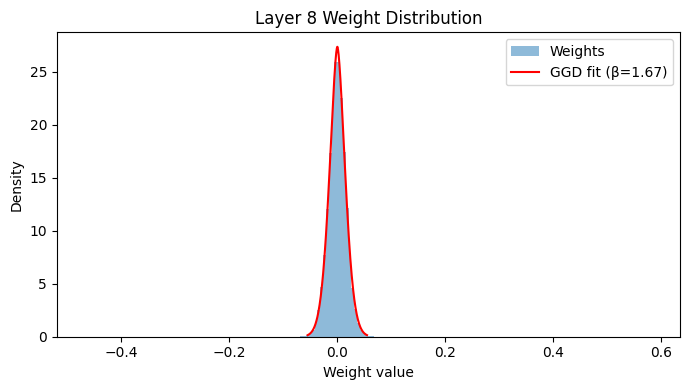

Mean KL to Gaussian: 0.0049 bits


In [6]:
# Fit GGD on a representative layer
flat = w_fp16.reshape(-1).astype(np.float32)

beta, loc, scale = gennorm.fit(flat)
print(f"GGD shape β = {beta:.2f} (2=Gaussian, 1=Laplacian)")

# One histogram plot
plt.figure(figsize=(7, 4))
plt.hist(flat, bins=200, density=True, alpha=0.5, label="Weights")

xs = np.linspace(np.percentile(flat, 0.1), np.percentile(flat, 99.9), 300)
plt.plot(xs, gennorm.pdf(xs, beta, loc=loc, scale=scale), "r-", label=f"GGD fit (β={beta:.2f})")
plt.title(f"Layer {target_layer} Weight Distribution")
plt.xlabel("Weight value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Mean KL to Gaussian (no per-layer table)

def kl_to_gaussian(flat, bins=200):
    flat = flat.astype(np.float32)
    mu = float(np.mean(flat))
    sigma = float(np.std(flat))

    hist, bin_edges = np.histogram(flat, bins=bins, density=False)
    hist = hist.astype(np.float64)
    hist = hist / np.maximum(hist.sum(), 1.0)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    bin_widths = (bin_edges[1:] - bin_edges[:-1])
    gaussian_pdf = stats.norm.pdf(bin_centers, mu, sigma)
    gaussian_p = gaussian_pdf * bin_widths
    gaussian_p = gaussian_p / np.maximum(gaussian_p.sum(), 1.0)

    return float(entropy(hist + 1e-12, gaussian_p + 1e-12, base=2))

max_samples = 200_000
rng = np.random.default_rng(0)
kl_vals = []
for layer_idx in range(len(model.model.layers)):
    w = model.model.layers[layer_idx].mlp.down_proj.weight.detach().cpu().float().numpy()
    flat = w.reshape(-1)
    if flat.size > max_samples:
        flat = rng.choice(flat, size=max_samples, replace=False)
    kl_vals.append(kl_to_gaussian(flat, bins=200))

mean_kl = float(np.mean(kl_vals))
print(f"Mean KL to Gaussian: {mean_kl:.4f} bits")

## 5. Gap Analysis

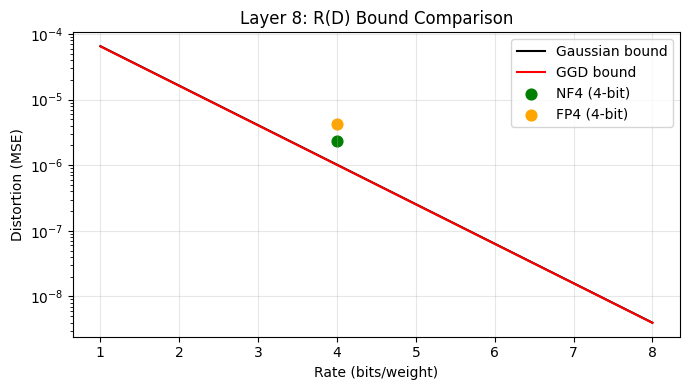

Entropy: Gaussian=-3.90, GGD=-3.91, Bonus=0.01 bits
GGD bound @4 bits: 1.01e-06
NF4 gap from GGD bound: 0.60 bits


In [7]:
# Entropy bounds

def ggd_entropy(beta, alpha):
    return (1.0 / (beta * np.log(2.0))) - np.log2(beta / (2.0 * alpha * gamma(1.0 / beta)))


def gaussian_entropy(sigma):
    return 0.5 * np.log2(2.0 * np.pi * np.e * sigma ** 2)


def distortion_bound_from_entropy(h_bits, rates):
    return (2 ** (2 * (h_bits - rates))) / (2 * np.pi * np.e)

h_gaussian = gaussian_entropy(sigma)
h_ggd = ggd_entropy(beta, scale)
bonus = h_gaussian - h_ggd

rates = np.linspace(1.0, 8.0, 200)
d_gauss = sigma ** 2 / (4 ** rates)
d_ggd = distortion_bound_from_entropy(h_ggd, rates)

plt.figure(figsize=(7, 4))
plt.plot(rates, d_gauss, label="Gaussian bound", color="black")
plt.plot(rates, d_ggd, label="GGD bound", color="red")

if mse_nf4 is not None:
    plt.scatter([4.0], [mse_nf4], color="green", s=60, label="NF4 (4-bit)")
if mse_fp4 is not None:
    plt.scatter([4.0], [mse_fp4], color="orange", s=60, label="FP4 (4-bit)")

plt.yscale("log")
plt.xlabel("Rate (bits/weight)")
plt.ylabel("Distortion (MSE)")
plt.title(f"Layer {target_layer}: R(D) Bound Comparison")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Entropy: Gaussian={h_gaussian:.2f}, GGD={h_ggd:.2f}, Bonus={bonus:.2f} bits")

# Gap quantification at 4 bits
bound_ggd_4 = float(distortion_bound_from_entropy(h_ggd, 4.0))
print(f"GGD bound @4 bits: {bound_ggd_4:.2e}")

if mse_nf4 is not None:
    gap_bits_nf4 = 0.5 * np.log2(mse_nf4 / bound_ggd_4)
    print(f"NF4 gap from GGD bound: {gap_bits_nf4:.2f} bits")

### 5.1 Gaussian test-channel upper bound (sandwich the SLB)


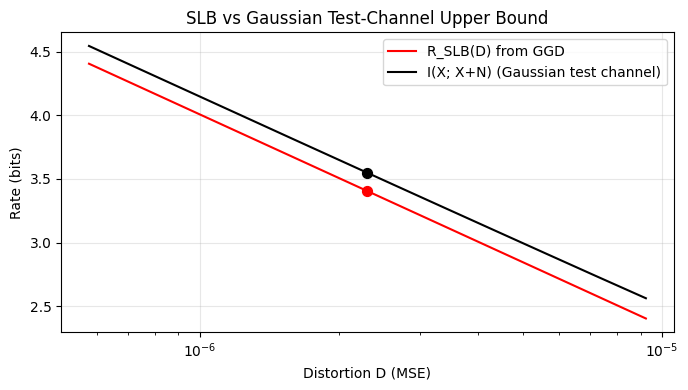

At D = mse_nf4 = 2.307e-06: R_SLB = 3.405 bits, I_upper = 3.548 bits, gap <= 0.143 bits


In [8]:
# Gaussian test-channel: Y = X + N, N ~ N(0, D)
# Gives an upper bound on R(D) via I(X;Y)

use_empirical_weights = True  # set False to sample from fitted GGD
max_samples = 200_000
bins_entropy = 400

rng = np.random.default_rng(1)

if use_empirical_weights:
    X = flat.astype(np.float32)
else:
    X = gennorm.rvs(beta, loc=loc, scale=scale, size=flat.size, random_state=rng).astype(np.float32)

if X.size > max_samples:
    X = rng.choice(X, size=max_samples, replace=False)


def differential_entropy_hist(samples, bins=400):
    hist, edges = np.histogram(samples, bins=bins, density=False)
    hist = hist.astype(np.float64)
    p = hist / np.maximum(hist.sum(), 1.0)
    bw = float(np.mean(edges[1:] - edges[:-1]))
    return float(-np.sum(p * np.log2(p + 1e-12)) + np.log2(bw))


def gaussian_noise_entropy(D):
    return 0.5 * np.log2(2.0 * np.pi * np.e * D)


def slb_rate(D, h_bits):
    return h_bits - 0.5 * np.log2(2.0 * np.pi * np.e * D)


def estimate_I_upper(X, D, rng, bins=400):
    noise = rng.normal(0.0, np.sqrt(D), size=X.shape).astype(np.float32)
    Y = X + noise
    h_Y = differential_entropy_hist(Y, bins=bins)
    return h_Y - gaussian_noise_entropy(D)


# Distortion grid (centered around mse_nf4 when available)
if mse_nf4 is not None:
    D_ref = float(mse_nf4)
else:
    D_ref = float(distortion_bound_from_entropy(h_ggd, 4.0))

D_min = D_ref / 4.0
D_max = D_ref * 4.0
D_grid = np.logspace(np.log10(D_min), np.log10(D_max), 12)

I_upper = []
for D in D_grid:
    I_upper.append(estimate_I_upper(X, D, rng, bins=bins_entropy))
I_upper = np.array(I_upper)

R_slb = slb_rate(D_grid, h_ggd)

# Numbers at the reference distortion
I_ref = estimate_I_upper(X, D_ref, rng, bins=bins_entropy)
R_ref = slb_rate(D_ref, h_ggd)
Delta_ref = I_ref - R_ref

plt.figure(figsize=(7, 4))
plt.plot(D_grid, R_slb, label="R_SLB(D) from GGD", color="red")
plt.plot(D_grid, I_upper, label="I(X; X+N) (Gaussian test channel)", color="black")
plt.scatter([D_ref], [R_ref], color="red", s=50)
plt.scatter([D_ref], [I_ref], color="black", s=50)

plt.xscale("log")
plt.xlabel("Distortion D (MSE)")
plt.ylabel("Rate (bits)")
plt.title("SLB vs Gaussian Test-Channel Upper Bound")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

if mse_nf4 is not None:
    print(
        f"At D = mse_nf4 = {D_ref:.3e}: R_SLB = {R_ref:.3f} bits, "
        f"I_upper = {I_ref:.3f} bits, gap <= {Delta_ref:.3f} bits"
    )
else:
    print(
        f"At D_ref = {D_ref:.3e}: R_SLB = {R_ref:.3f} bits, "
        f"I_upper = {I_ref:.3f} bits, gap <= {Delta_ref:.3f} bits"
    )


### 5.2 Discrete RD solver (numeric R(D) for fitted GGD)


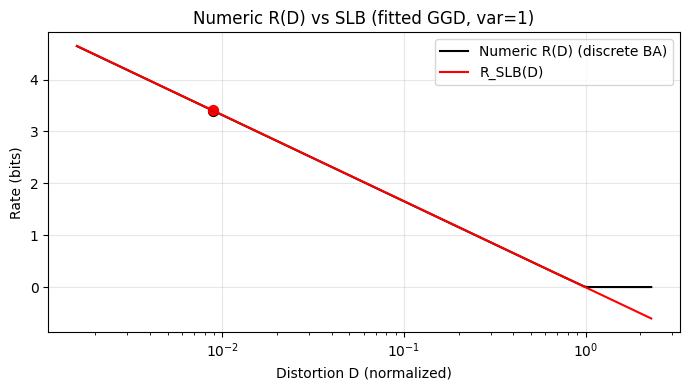

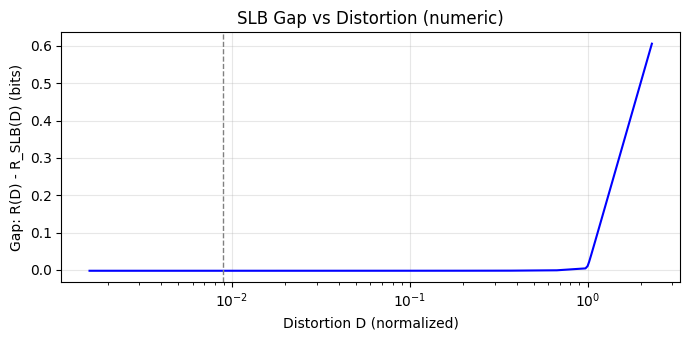

At D_ref = 8.850e-03 (normalized): R(D) = 3.402 bits, R_SLB = 3.405 bits, gap = -0.002 bits
 beta  D_ref_norm  R_at_D_ref  R_SLB_at_D_ref  gap_bits
  1.3     0.00885    3.372981        3.375391 -0.002410
  1.7     0.00885    3.403501        3.405856 -0.002354
  2.0     0.00885    3.407777        3.410075 -0.002298


In [9]:
# Discrete RD solver (Blahut–Arimoto) for fitted GGD, normalized to var=1

n_bins_rd = 201
p_low = 1e-4
p_high = 1 - 1e-4
lambdas = np.logspace(-2.5, 2.5, 20)
max_iter = 120
tol = 1e-7

# Std-dev of fitted GGD (for normalization)
sigma_ggd = float(scale * np.sqrt(gamma(3.0 / beta) / gamma(1.0 / beta)))
scale_std = float(scale / sigma_ggd)

h_ggd_std = ggd_entropy(beta, scale_std)


def make_ggd_pmf(beta_shape, scale_param, n_bins=201, p_low=1e-4, p_high=1 - 1e-4):
    dist = stats.gennorm(beta_shape, loc=0.0, scale=scale_param)
    x_min = float(dist.ppf(p_low))
    x_max = float(dist.ppf(p_high))
    edges = np.linspace(x_min, x_max, n_bins + 1)
    cdf = dist.cdf(edges)
    p = np.diff(cdf)
    p = p / np.maximum(p.sum(), 1e-12)
    centers = 0.5 * (edges[:-1] + edges[1:])
    return centers.astype(np.float64), p.astype(np.float64)


def rd_curve_discrete(x, p_x, xhat, lambdas, max_iter=100, tol=1e-7):
    d = (x[:, None] - xhat[None, :]) ** 2
    R_list, D_list = [], []
    for lam in lambdas:
        q = np.ones(xhat.size, dtype=np.float64) / xhat.size
        for _ in range(max_iter):
            log_q = np.log(q + 1e-12)
            z = log_q[None, :] - lam * d
            z = z - z.max(axis=1, keepdims=True)
            p_yx = np.exp(z)
            p_yx = p_yx / np.maximum(p_yx.sum(axis=1, keepdims=True), 1e-12)
            q_new = (p_x[:, None] * p_yx).sum(axis=0)
            if np.sum(np.abs(q_new - q)) < tol:
                q = q_new
                break
            q = q_new

        D = float((p_x[:, None] * p_yx * d).sum())
        R = float((p_x[:, None] * p_yx * (np.log2(p_yx + 1e-12) - np.log2(q + 1e-12))).sum())
        D_list.append(D)
        R_list.append(R)

    return np.array(D_list), np.array(R_list)


# Fitted-beta RD curve (normalized)
x_grid, p_x = make_ggd_pmf(beta, scale_std, n_bins_rd, p_low, p_high)
xhat = x_grid.copy()
D_vals, R_vals = rd_curve_discrete(x_grid, p_x, xhat, lambdas, max_iter=max_iter, tol=tol)

order = np.argsort(D_vals)
D_vals, R_vals = D_vals[order], R_vals[order]
R_slb_vals = slb_rate(D_vals, h_ggd_std)

# Reference distortion in normalized units
if mse_nf4 is not None:
    D_ref = float(mse_nf4) / (sigma_ggd ** 2)
else:
    D_ref = float(bound_ggd_4) / (sigma_ggd ** 2)

if D_ref < D_vals.min() or D_ref > D_vals.max():
    print("Warning: D_ref outside RD curve range; consider expanding lambdas or grid.")

R_ref = float(np.interp(np.log(D_ref), np.log(D_vals), R_vals))
R_slb_ref = float(slb_rate(D_ref, h_ggd_std))
Gap_ref = R_ref - R_slb_ref

plt.figure(figsize=(7, 4))
plt.plot(D_vals, R_vals, label="Numeric R(D) (discrete BA)", color="black")
plt.plot(D_vals, R_slb_vals, label="R_SLB(D)", color="red")
plt.scatter([D_ref], [R_ref], color="black", s=50)
plt.scatter([D_ref], [R_slb_ref], color="red", s=50)
plt.xscale("log")
plt.xlabel("Distortion D (normalized)")
plt.ylabel("Rate (bits)")
plt.title("Numeric R(D) vs SLB (fitted GGD, var=1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 3.5))
plt.plot(D_vals, R_vals - R_slb_vals, color="blue")
plt.axvline(D_ref, color="gray", linestyle="--", linewidth=1)
plt.xscale("log")
plt.xlabel("Distortion D (normalized)")
plt.ylabel("Gap: R(D) - R_SLB(D) (bits)")
plt.title("SLB Gap vs Distortion (numeric)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(
    f"At D_ref = {D_ref:.3e} (normalized): R(D) = {R_ref:.3f} bits, "
    f"R_SLB = {R_slb_ref:.3f} bits, gap = {Gap_ref:.3f} bits"
)

# Table across a few beta values (variance-normalized)
beta_list = [1.3, 1.7, 2.0]
rows = []
for b in beta_list:
    scale_b = float(np.sqrt(gamma(1.0 / b) / gamma(3.0 / b)))  # var=1
    h_b = ggd_entropy(b, scale_b)
    x_b, p_b = make_ggd_pmf(b, scale_b, n_bins_rd, p_low, p_high)
    D_b, R_b = rd_curve_discrete(x_b, p_b, x_b, lambdas, max_iter=max_iter, tol=tol)

    order_b = np.argsort(D_b)
    D_b, R_b = D_b[order_b], R_b[order_b]

    if D_ref < D_b.min() or D_ref > D_b.max():
        gap_b = np.nan
        R_b_ref = np.nan
        R_slb_b_ref = np.nan
    else:
        R_b_ref = float(np.interp(np.log(D_ref), np.log(D_b), R_b))
        R_slb_b_ref = float(slb_rate(D_ref, h_b))
        gap_b = R_b_ref - R_slb_b_ref

    rows.append({
        "beta": b,
        "D_ref_norm": D_ref,
        "R_at_D_ref": R_b_ref,
        "R_SLB_at_D_ref": R_slb_b_ref,
        "gap_bits": gap_b,
    })

beta_gap_df = pd.DataFrame(rows)
print(beta_gap_df.to_string(index=False))


## 6. Summary

In [10]:
summary_rows = []

if mse_nf4 is not None and not functional_summary.empty:
    row = functional_summary[functional_summary["method"] == "bnb 4-bit NF4"].iloc[0]
    summary_rows.append({
        "method": "bnb 4-bit NF4",
        "weight_mse": row["weight_mse"],
        "logits_mse": row["logits_mse"],
        "delta_ce": row["delta_ce"],
        "amplification": row["amplification"],
        "gap_bits_vs_gauss": 0.5 * np.log2(row["weight_mse"] / d_shannon_gauss),
        "gap_bits_vs_ggd": 0.5 * np.log2(row["weight_mse"] / bound_ggd_4),
    })

if mse_fp4 is not None and not functional_summary.empty:
    row = functional_summary[functional_summary["method"] == "bnb 4-bit FP4"].iloc[0]
    summary_rows.append({
        "method": "bnb 4-bit FP4",
        "weight_mse": row["weight_mse"],
        "logits_mse": row["logits_mse"],
        "delta_ce": row["delta_ce"],
        "amplification": row["amplification"],
        "gap_bits_vs_gauss": 0.5 * np.log2(row["weight_mse"] / d_shannon_gauss),
        "gap_bits_vs_ggd": 0.5 * np.log2(row["weight_mse"] / bound_ggd_4),
    })

summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))

       method  weight_mse  logits_mse  delta_ce  amplification  gap_bits_vs_gauss  gap_bits_vs_ggd
bnb 4-bit NF4    0.000002    1.600312  0.046875  693556.213560           0.589341         0.595167
bnb 4-bit FP4    0.000004    2.039990  0.055885  481544.151612           1.027617         1.033444
